This script implements a complete machine learning pipeline for mental health diagnosis
classification using patient symptom data. The pipeline includes data preprocessing,
exploratory data analysis, feature engineering, model development, and evaluation.


Dataset: Mental health assessment data with 17 features and 4 diagnosis classes
Target: Predict mental health diagnosis (Normal, Depression, Bipolar Type-1, Bipolar Type-2)

# Import required libraries

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

 1. DATA LOADING AND INITIAL EXPLORATION

Load the mental health dataset and perform initial data exploration to understand
the structure, size, and basic characteristics of the data.

In [38]:
df = pd.read_csv("C:/Users/educa/Desktop/MentalHealth/Dataset-Mental-Disorders.csv")


In [40]:
print("="*60)
print("1. INITIAL DATA EXPLORATION")
print("="*60)
print("Dataset shape:", df.shape)
print(f"Number of patients: {df.shape[0]}")
print(f"Number of features: {df.shape[1]-1}")  # Excluding target variable
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nTarget variable distribution:")
print(df['Expert Diagnose'].value_counts())

1. INITIAL DATA EXPLORATION
Dataset shape: (120, 19)
Number of patients: 120
Number of features: 18

First few rows:
  Patient Number    Sadness    Euphoric  Exhausted Sleep dissorder Mood Swing  \
0     Patiant-01    Usually      Seldom  Sometimes       Sometimes        YES   
1     Patiant-02    Usually      Seldom    Usually       Sometimes         NO   
2     Patiant-03  Sometimes  Most-Often  Sometimes       Sometimes        YES   
3     Patiant-04    Usually      Seldom    Usually      Most-Often        YES   
4     Patiant-05    Usually     Usually  Sometimes       Sometimes         NO   

  Suicidal thoughts Anorxia Authority Respect Try-Explanation  \
0              YES       NO                NO             YES   
1               YES      NO                NO              NO   
2                NO      NO                NO             YES   
3               YES     YES                NO             YES   
4                NO      NO                NO              NO   

  Agg

# DATA PREPROCESSING

In [42]:
def preprocess_data(df):
    """
    Comprehensive data preprocessing for mental health dataset
    """
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Drop patient number as it's not a feature
    if 'Patient Number' in df_processed.columns:
        df_processed = df_processed.drop('Patient Number', axis=1)
    
    # Clean whitespace and fix typos
    df_processed.columns = df_processed.columns.str.strip()
    df_processed = df_processed.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    
    # Fix column name typo
    if 'Anorxia' in df_processed.columns:
        df_processed = df_processed.rename(columns={'Anorxia': 'Anorexia'})
    
    # Handle ordinal features (frequency-based)
    ordinal_features = ['Sadness', 'Euphoric', 'Exhausted', 'Sleep dissorder']
    ordinal_mapping = {'Seldom': 1, 'Sometimes': 2, 'Usually': 3, 'Most-Often': 4}
    
    for col in ordinal_features:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].map(ordinal_mapping)
    
    # Handle binary features
    binary_features = ['Mood Swing', 'Suicidal thoughts', 'Anorexia', 'Authority Respect', 
                      'Try-Explanation', 'Aggressive Response', 'Ignore & Move-On', 
                      'Nervous Break-down', 'Admit Mistakes', 'Overthinking']
    
    for col in binary_features:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].map({'YES': 1, 'NO': 0})
    
    # Handle numerical features (extract numbers from "X From 10" format)
    numerical_features = ['Sexual Activity', 'Concentration', 'Optimisim']
    for col in numerical_features:
        if col in df_processed.columns:
            # Extract number before "From 10"
            df_processed[col] = df_processed[col].str.extract('(\d+)').astype(int)
    
    # Encode target variable with proper mapping
    target_mapping = {'Normal': 0, 'Depression': 1, 'Bipolar Type-1': 2, 'Bipolar Type-2': 3}
    df_processed['Expert Diagnose'] = df_processed['Expert Diagnose'].map(target_mapping)
    
    return df_processed

In [44]:
# Apply preprocessing
df_clean = preprocess_data(df)
print("\nAfter preprocessing:")
print(df_clean.head())
print("\nData types:")
print(df_clean.dtypes)
print("\nMissing values:")
print(df_clean.isnull().sum())


After preprocessing:
   Sadness  Euphoric  Exhausted  Sleep dissorder  Mood Swing  \
0        3         1          2                2           1   
1        3         1          3                2           0   
2        2         4          2                2           1   
3        3         1          3                4           1   
4        3         3          2                2           0   

   Suicidal thoughts  Anorexia  Authority Respect  Try-Explanation  \
0                  1         0                  0                1   
1                  1         0                  0                0   
2                  0         0                  0                1   
3                  1         1                  0                1   
4                  0         0                  0                0   

   Aggressive Response  Ignore & Move-On  Nervous Break-down  Admit Mistakes  \
0                    0                 0                   1               1   
1           

# EXPLORATORY DATA ANALYSIS

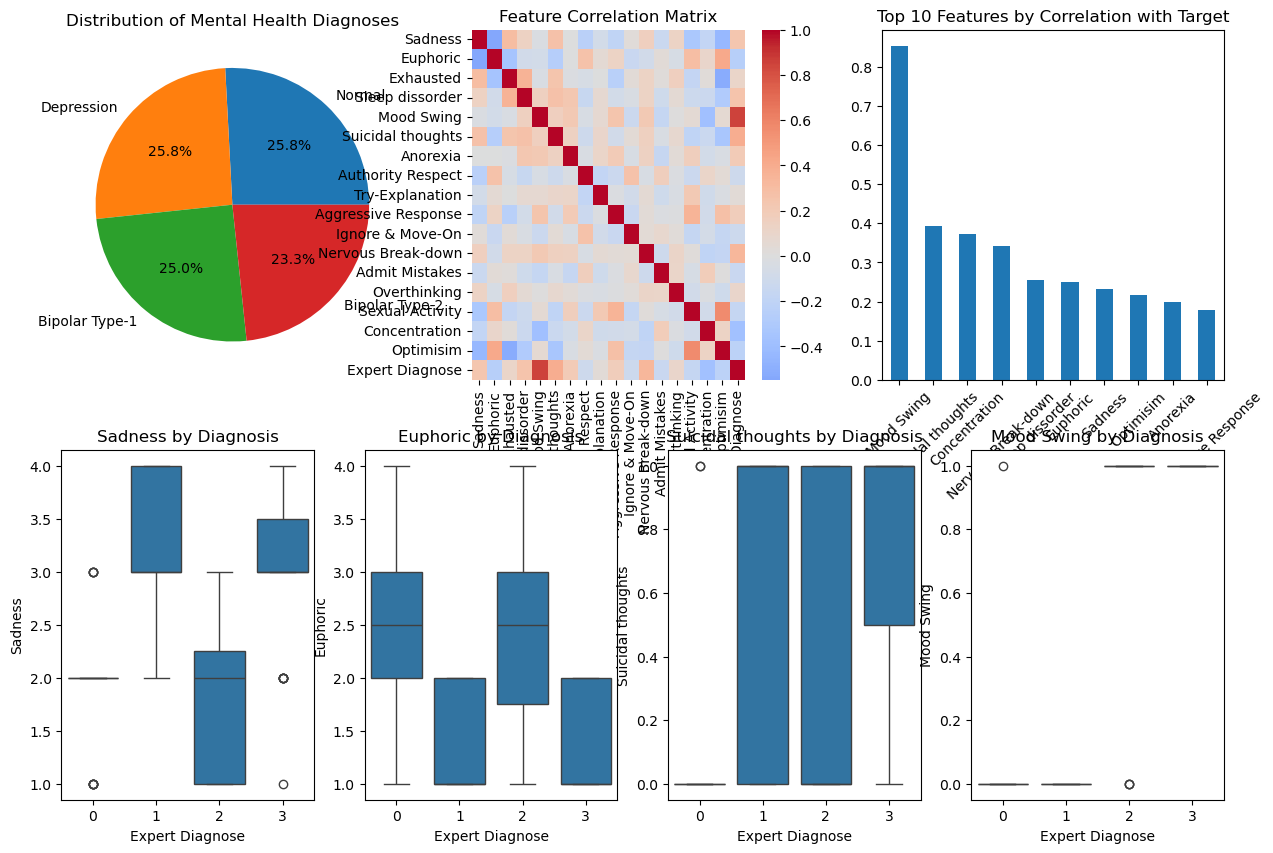


Top correlated features with target:
Mood Swing             0.852568
Suicidal thoughts      0.392923
Concentration          0.372282
Nervous Break-down     0.340790
Sleep dissorder        0.254723
Euphoric               0.249619
Sadness                0.233247
Optimisim              0.216569
Anorexia               0.197978
Aggressive Response    0.177803
dtype: float64


In [46]:
def perform_eda(df):
    """
    Comprehensive EDA for mental health dataset
    """
    plt.figure(figsize=(15, 10))
    
    # Target distribution
    plt.subplot(2, 3, 1)
    target_counts = df['Expert Diagnose'].value_counts()
    target_labels = ['Normal', 'Depression', 'Bipolar Type-1', 'Bipolar Type-2']
    plt.pie(target_counts.values, labels=target_labels, autopct='%1.1f%%')
    plt.title('Distribution of Mental Health Diagnoses')
    
    # Correlation heatmap
    plt.subplot(2, 3, 2)
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    # Feature importance by target
    plt.subplot(2, 3, 3)
    feature_cols = df.columns[:-1]  # All except target
    target_corr = df[feature_cols].corrwith(df['Expert Diagnose']).abs().sort_values(ascending=False)
    top_features = target_corr.head(10)
    top_features.plot(kind='bar')
    plt.title('Top 10 Features by Correlation with Target')
    plt.xticks(rotation=45)
    
    # Box plots for key features
    key_features = ['Sadness', 'Euphoric', 'Suicidal thoughts', 'Mood Swing']
    for i, feature in enumerate(key_features[:4]):
        plt.subplot(2, 4, i+5)
        if feature in df.columns:
            sns.boxplot(data=df, x='Expert Diagnose', y=feature)
            plt.title(f'{feature} by Diagnosis')
    
    plt.tight_layout()
    plt.show()
    
    return top_features

top_features = perform_eda(df_clean)
print("\nTop correlated features with target:")
print(top_features)

# ADVANCED MODEL DEVELOPMENT

# Prepare features and target

In [48]:
X = df_clean.drop('Expert Diagnose', axis=1)
y = df_clean['Expert Diagnose']

In [50]:
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts().sort_index()}")


Feature matrix shape: (120, 17)
Target distribution:
Expert Diagnose
0    30
1    31
2    28
3    31
Name: count, dtype: int64


# Stratified split to maintain class distribution

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling (important for SVM and Logistic Regression)

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODEL TRAINING WITH HYPERPARAMETER TUNING

In [68]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train multiple models with hyperparameter tuning
    """
    models = {}
    results = {}
    
    # Stratified K-Fold for cross-validation
    print("Setting up cross-validation:")
    print("   - Using StratifiedKFold with 5 splits")
    print("   - Maintains class distribution in each fold")
    print("   - Scoring metric: F1-weighted (handles class imbalance)")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 1. Random Forest with GridSearch
    print(f"\n{'='*20} MODEL 1: RANDOM FOREST {'='*20}")
    print("Training Random Forest with hyperparameter tuning...")
    print("   - Ensemble of decision trees")
    print("   - Advantages: Feature importance, handles mixed data types")
    print("   - Uses original (unscaled) data")
    rf_params = {
         'n_estimators': [100, 200],          # Number of trees
        'max_depth': [None, 10, 20],         # Tree depth (None = unlimited)
        'min_samples_split': [2, 5],         # Min samples to split node
        'min_samples_leaf': [1, 2]           # Min samples in leaf node
    }
    print("   - Hyperparameter grid:")
    for param, values in rf_params.items():
        print(f"     {param}: {values}")
        
    rf = RandomForestClassifier(random_state=42)
    rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring='f1_weighted', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    
    models['Random Forest'] = rf_grid.best_estimator_
    print(f"   - Best parameters: {rf_grid.best_params_}")
    print(f"   - Best CV score: {rf_grid.best_score_:.4f}")

    # 2. Gradient Boosting
    print(f"\n{'='*18} MODEL 2: GRADIENT BOOSTING {'='*18}")
    print("Training Gradient Boosting with hyperparameter tuning...")
    print("   - Sequential ensemble building")
    print("   - Advantages: High accuracy, handles complex patterns")
    print("   - Uses original (unscaled) data")

    gb_params = {
        'n_estimators': [100, 200],          # Number of boosting stages
        'learning_rate': [0.05, 0.1, 0.2],   # Step size shrinkage
        'max_depth': [3, 5, 7]               # Individual tree depth
    }
    gb = GradientBoostingClassifier(random_state=42)
    gb_grid = GridSearchCV(gb, gb_params, cv=cv, scoring='f1_weighted', n_jobs=-1)
    gb_grid.fit(X_train, y_train)
    
    models['Gradient Boosting'] = gb_grid.best_estimator_
    print(f"   - Best parameters: {gb_grid.best_params_}")
    print(f"   - Best CV score: {gb_grid.best_score_:.4f}")

    # 3. Logistic Regression (with scaled data)
    print(f"\n{'='*17} MODEL 3: LOGISTIC REGRESSION {'='*17}")
    print("Training Logistic Regression with hyperparameter tuning...")
    print("   - Linear classifier with probabilistic output")
    print("   - Advantages: Interpretable, fast, good baseline")
    print("   - Uses scaled data (required for proper regularization)")

    lr_params = {
        'C': [0.1, 1, 10],                   # Inverse regularization strength
        'penalty': ['l1', 'l2'],             # Regularization type
        'solver': ['liblinear']              # Optimization algorithm
    }
    print("   - Hyperparameter grid:")
    for param, values in lr_params.items():
        print(f"     {param}: {values}")
        
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr_grid = GridSearchCV(lr, lr_params, cv=cv, scoring='f1_weighted', n_jobs=-1)
    lr_grid.fit(X_train_scaled, y_train)
    
    models['Logistic Regression'] = lr_grid.best_estimator_
    print(f"   - Best parameters: {lr_grid.best_params_}")
    print(f"   - Best CV score: {lr_grid.best_score_:.4f}")

    # 4. SVM (with scaled data)
    print(f"\n{'='*16} MODEL 4: SUPPORT VECTOR MACHINE {'='*16}")
    print("Training SVM with hyperparameter tuning...")
    print("   - Finds optimal decision boundary (maximum margin)")
    print("   - Advantages: Effective for small datasets, kernel trick")
    print("   - Uses scaled data (required for distance-based algorithm)")

    svm_params = {
        'C': [0.1, 1, 10],                   # Regularization parameter
        'kernel': ['rbf', 'linear'],         # Kernel function
        'gamma': ['scale', 'auto']           # Kernel coefficient (for rbf)
    }
    print("   - Hyperparameter grid:")
    for param, values in svm_params.items():
        print(f"     {param}: {values}")
        
    svm = SVC(random_state=42, probability=True)  # Enable probability for ensemble
    svm_grid = GridSearchCV(svm, svm_params, cv=cv, scoring='f1_weighted', n_jobs=-1)
    svm_grid.fit(X_train_scaled, y_train)
    
    models['SVM'] = svm_grid.best_estimator_
    print(f"   - Best parameters: {svm_grid.best_params_}")
    print(f"   - Best CV score: {svm_grid.best_score_:.4f}")

    # Evaluate all models

    print(f"\n{'='*20} MODEL EVALUATION {'='*20}")
    target_names = ['Normal', 'Depression', 'Bipolar Type-1', 'Bipolar Type-2']
    
    for name, model in models.items():
        print(f"\n--- {name} Results ---")

        # Make predictions
        if name in ['Logistic Regression', 'SVM']:
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)
        else:
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        if name in ['Logistic Regression', 'SVM']:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')
        
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        #print(f"\n{name} Results:")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test F1-Score: {f1:.4f}")
        print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=target_names))
    
    return models, results

In [70]:
# Train and evaluate models
models, results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

Setting up cross-validation:
   - Using StratifiedKFold with 5 splits
   - Maintains class distribution in each fold
   - Scoring metric: F1-weighted (handles class imbalance)

==================== MODEL 1: RANDOM FOREST ====================
Training Random Forest with hyperparameter tuning...
   - Ensemble of decision trees
   - Advantages: Feature importance, handles mixed data types
   - Uses original (unscaled) data
   - Hyperparameter grid:
     n_estimators: [100, 200]
     max_depth: [None, 10, 20]
     min_samples_split: [2, 5]
     min_samples_leaf: [1, 2]
   - Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
   - Best CV score: 0.8838

================== MODEL 2: GRADIENT BOOSTING ==================
Training Gradient Boosting with hyperparameter tuning...
   - Sequential ensemble building
   - Advantages: High accuracy, handles complex patterns
   - Uses original (unscaled) data
   - Best parameters: {'learning_rate': 0.

# FEATURE IMPORTANCE ANALYSIS

In [72]:

def analyze_feature_importance(models, feature_names):
    """
    Analyze and visualize feature importance
    """
    plt.figure(figsize=(15, 10))
    
    # Random Forest feature importance
    if 'Random Forest' in models:
        plt.subplot(2, 2, 1)
        rf_importance = models['Random Forest'].feature_importances_
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': rf_importance
        }).sort_values('importance', ascending=False)
        
        top_features = feature_imp_df.head(10)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.title('Random Forest - Top 10 Feature Importance')
        plt.xlabel('Importance')
    
    # Gradient Boosting feature importance
    if 'Gradient Boosting' in models:
        plt.subplot(2, 2, 2)
        gb_importance = models['Gradient Boosting'].feature_importances_
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': gb_importance
        }).sort_values('importance', ascending=False)
        
        top_features = feature_imp_df.head(10)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.title('Gradient Boosting - Top 10 Feature Importance')
        plt.xlabel('Importance')
    
    # Model comparison
    plt.subplot(2, 2, 3)
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    f1_scores = [results[name]['f1_score'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
    plt.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    
    # Confusion matrix for best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
    plt.subplot(2, 2, 4)
    cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Depression', 'Bipolar-1', 'Bipolar-2'],
                yticklabels=['Normal', 'Depression', 'Bipolar-1', 'Bipolar-2'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    return best_model_name

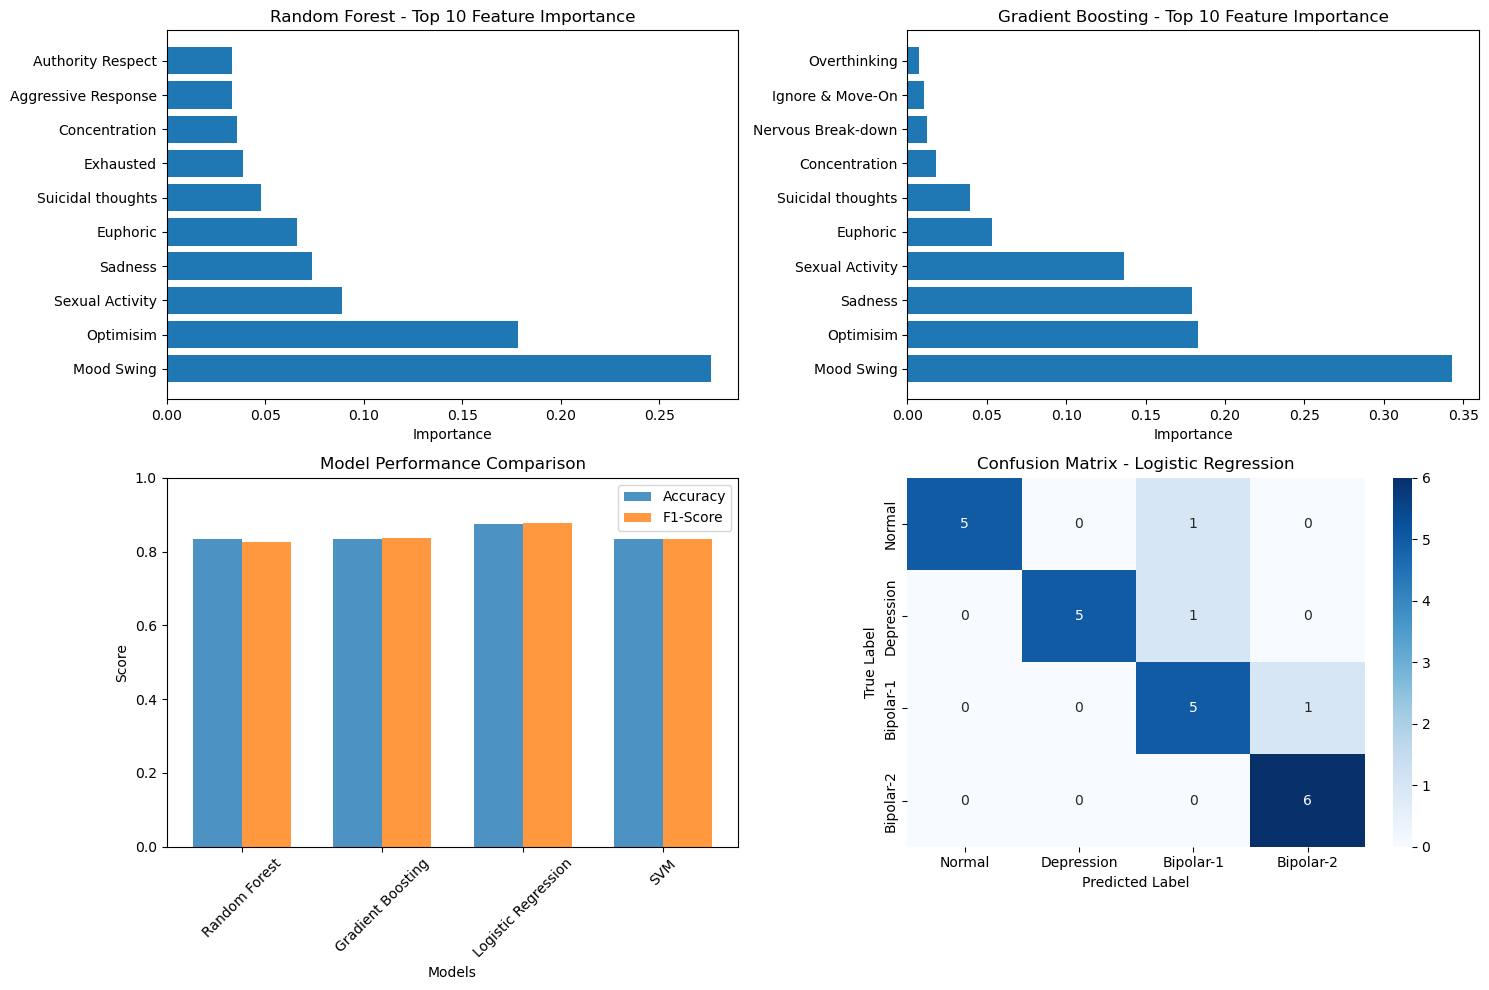


Best performing model: Logistic Regression
Best model performance: {'accuracy': 0.875, 'f1_score': 0.8776223776223775, 'cv_mean': 0.8532685881370092, 'cv_std': 0.08946656979773221, 'predictions': array([2, 2, 2, 3, 1, 0, 1, 0, 1, 2, 3, 3, 2, 1, 3, 2, 3, 2, 0, 0, 1, 3,
       0, 3], dtype=int64), 'probabilities': array([[1.92484781e-03, 9.98313042e-07, 9.73868366e-01, 2.42057874e-02],
       [1.33137377e-04, 3.04414989e-09, 5.05705984e-01, 4.94160876e-01],
       [1.40421253e-05, 6.45244631e-07, 9.99163664e-01, 8.21648430e-04],
       [4.68933310e-04, 1.21245679e-03, 1.13041997e-03, 9.97188190e-01],
       [6.96441922e-04, 9.96594963e-01, 1.41866720e-05, 2.69440805e-03],
       [9.81478117e-01, 1.74942133e-02, 1.02704149e-03, 6.28247694e-07],
       [1.49116969e-04, 5.95648994e-01, 3.61478718e-11, 4.04201889e-01],
       [9.93110397e-01, 6.85819440e-03, 1.14354355e-06, 3.02649605e-05],
       [1.28219746e-02, 9.83470026e-01, 2.14397174e-08, 3.70797769e-03],
       [1.09551757e-04, 7.54

In [74]:
# Analyze feature importance
feature_names = X.columns.tolist()
best_model_name = analyze_feature_importance(models, feature_names)

print(f"\nBest performing model: {best_model_name}")
print(f"Best model performance: {results[best_model_name]}")

# ENSEMBLE MODEL (BONUS)

In [76]:
def create_ensemble_model(models, X_train, X_test, y_train, y_test):
    """
    Create a simple voting ensemble
    """
    from sklearn.ensemble import VotingClassifier
    
    # Create ensemble with top 3 models
    ensemble_models = [
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting']),
        ('lr', models['Logistic Regression'])
    ]
    
    # Note: This is a simplified ensemble - in practice, you'd need to handle
    # the different preprocessing requirements for different models
    voting_clf = VotingClassifier(estimators=ensemble_models, voting='soft')
    voting_clf.fit(X_train, y_train)
    
    y_pred_ensemble = voting_clf.predict(X_test)
    accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
    f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')
    
    print(f"\nEnsemble Model Results:")
    print(f"Accuracy: {accuracy_ensemble:.4f}")
    print(f"F1-Score: {f1_ensemble:.4f}")
    
    return voting_clf

# Create ensemble (optional)
# ensemble_model = create_ensemble_model(models, X_train, X_test, y_train, y_test)

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)
print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Best F1-Score: {results[best_model_name]['f1_score']:.4f}")


ANALYSIS COMPLETE!
Best Model: Logistic Regression
Best Accuracy: 0.8750
Best F1-Score: 0.8776


#                      PREDICTION SYSTEM

In [78]:
class MentalHealthPredictor:
    """
    Complete prediction system for mental health classification
    """
    
    def __init__(self):
        self.models = {}
        self.scaler = None
        self.feature_names = None
        self.target_names = ['Normal', 'Depression', 'Bipolar Type-1', 'Bipolar Type-2']
        self.best_model_name = None
        
    def fit(self, X_train, X_test, y_train, y_test):
        """
        Train all models and find the best one
        """
        # Prepare scaled data
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Store feature names
        self.feature_names = X_train.columns.tolist()
        
        # Train models
        self.models, self.results = train_and_evaluate_models(
            X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled
        )
        
        # Find best model
        self.best_model_name = max(self.results.keys(), 
                                 key=lambda x: self.results[x]['f1_score'])
        
        print(f"\nBest performing model: {self.best_model_name}")
        print(f"Best F1-Score: {self.results[self.best_model_name]['f1_score']:.4f}")
        
        return self
    
    def predict_single(self, patient_data):
        """
        Predict mental health condition for a single patient
        
        Args:
            patient_data: Dictionary or DataFrame with patient symptoms
            
        Returns:
            Dictionary with prediction results
        """
        # Convert to DataFrame if dictionary
        if isinstance(patient_data, dict):
            patient_df = pd.DataFrame([patient_data])
        else:
            patient_df = patient_data.copy()
        
        # Ensure all features are present
        for feature in self.feature_names:
            if feature not in patient_df.columns:
                raise ValueError(f"Missing feature: {feature}")
        
        # Reorder columns to match training data
        patient_df = patient_df[self.feature_names]
        
        # Get best model
        best_model = self.results[self.best_model_name]['model']
        
        # Make prediction
        if self.best_model_name in ['Logistic Regression', 'SVM']:
            patient_scaled = self.scaler.transform(patient_df)
            prediction = best_model.predict(patient_scaled)[0]
            probabilities = best_model.predict_proba(patient_scaled)[0]
        else:
            prediction = best_model.predict(patient_df)[0]
            probabilities = best_model.predict_proba(patient_df)[0]
        
        # Prepare results
        result = {
            'predicted_class': self.target_names[prediction],
            'predicted_class_id': int(prediction),
            'confidence': float(probabilities[prediction]),
            'all_probabilities': {
                self.target_names[i]: float(prob) 
                for i, prob in enumerate(probabilities)
            },
            'model_used': self.best_model_name
        }
        
        return result
    
    def predict_batch(self, patients_data):
        """
        Predict mental health conditions for multiple patients
        """
        results = []
        for i, patient_data in patients_data.iterrows():
            result = self.predict_single(patient_data)
            result['patient_id'] = i
            results.append(result)
        return results
    
    def explain_prediction(self, patient_data):
        """
        Provide detailed explanation of the prediction
        """
        prediction_result = self.predict_single(patient_data)
        
        # Get feature importance (for tree-based models)
        if self.best_model_name in ['Random Forest', 'Gradient Boosting']:
            model = self.results[self.best_model_name]['model']
            feature_importance = model.feature_importances_
            
            # Convert patient data to DataFrame if needed
            if isinstance(patient_data, dict):
                patient_df = pd.DataFrame([patient_data])
            else:
                patient_df = patient_data.copy()
            
            # Calculate feature contributions
            patient_values = patient_df[self.feature_names].values[0]
            contributions = feature_importance * abs(patient_values)
            
            # Sort by contribution
            feature_contributions = list(zip(self.feature_names, contributions, patient_values))
            feature_contributions.sort(key=lambda x: x[1], reverse=True)
            
            explanation = {
                'prediction': prediction_result,
                'top_contributing_features': [
                    {
                        'feature': feature,
                        'contribution': float(contrib),
                        'patient_value': float(value)
                    }
                    for feature, contrib, value in feature_contributions[:5]
                ]
            }
        else:
            explanation = {
                'prediction': prediction_result,
                'note': f"Feature importance not available for {self.best_model_name}"
            }
        
        return explanation
    
    def save_model(self, filepath):
        """
        Save the trained model system
        """
        model_data = {
            'models': self.models,
            'results': self.results,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'target_names': self.target_names,
            'best_model_name': self.best_model_name
        }
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load a trained model system
        """
        model_data = joblib.load(filepath)
        self.models = model_data['models']
        self.results = model_data['results']
        self.scaler = model_data['scaler']
        self.feature_names = model_data['feature_names']
        self.target_names = model_data['target_names']
        self.best_model_name = model_data['best_model_name']
        print(f"Model loaded from {filepath}")

#                      EXAMPLE USAGE AND TESTING

In [80]:
def create_sample_patient():
    """
    Create a sample patient for testing predictions
    """
    sample_patient = {
        'Sadness': 3,  # Usually
        'Euphoric': 1,  # Seldom
        'Exhausted': 2,  # Sometimes
        'Sleep dissorder': 3,  # Usually
        'Mood Swing': 1,  # YES
        'Suicidal thoughts': 0,  # NO
        'Anorexia': 0,  # NO
        'Authority Respect': 1,  # YES
        'Try-Explanation': 1,  # YES
        'Aggressive Response': 0,  # NO
        'Ignore & Move-On': 1,  # YES
        'Nervous Break-down': 0,  # NO
        'Admit Mistakes': 1,  # YES
        'Overthinking': 1,  # YES
        'Sexual Activity': 3,  # 3 from 10
        'Concentration': 4,  # 4 from 10
        'Optimisim': 3   # 3 from 10
    }
    return sample_patient

In [82]:
def demonstrate_prediction_system():
    """
    Demonstrate the complete prediction system
    """
    print("\n" + "="*60)
    print("         PREDICTION SYSTEM DEMONSTRATION")
    print("="*60)
    
    # Create sample patients
    sample_patients = [
        {
            'Sadness': 4, 'Euphoric': 1, 'Exhausted': 4, 'Sleep dissorder': 3,
            'Mood Swing': 1, 'Suicidal thoughts': 1, 'Anorexia': 0, 'Authority Respect': 0,
            'Try-Explanation': 0, 'Aggressive Response': 1, 'Ignore & Move-On': 0,
            'Nervous Break-down': 1, 'Admit Mistakes': 0, 'Overthinking': 1,
            'Sexual Activity': 2, 'Concentration': 3, 'Optimisim': 2
        },
        {
            'Sadness': 1, 'Euphoric': 1, 'Exhausted': 1, 'Sleep dissorder': 1,
            'Mood Swing': 0, 'Suicidal thoughts': 0, 'Anorexia': 0, 'Authority Respect': 1,
            'Try-Explanation': 1, 'Aggressive Response': 0, 'Ignore & Move-On': 1,
            'Nervous Break-down': 0, 'Admit Mistakes': 1, 'Overthinking': 0,
            'Sexual Activity': 7, 'Concentration': 8, 'Optimisim': 8
        }
    ]
    
    for i, patient in enumerate(sample_patients, 1):
        print(f"\n--- Sample Patient {i} ---")
        print("Input symptoms:")
        for symptom, value in patient.items():
            print(f"  {symptom}: {value}")
        
        # Make prediction (assuming predictor is trained)
        # result = predictor.predict_single(patient)
        # explanation = predictor.explain_prediction(patient)
        
        print("\nPrediction would be made here...")
        print("(Train the model first using the complete pipeline)")

#                      COMPLETE PIPELINE FUNCTION

In [84]:
def run_complete_pipeline(df):
    """
    Run the complete mental health classification pipeline
    
    Args:
        df: Raw dataset
        
    Returns:
        predictor: Trained prediction system
    """
    print("="*80)
    print("         MENTAL HEALTH CLASSIFICATION PIPELINE")
    print("="*80)
    
    # 1. Data Preprocessing (use your existing preprocess_data function)
    print("\nStep 1: Data Preprocessing...")
    df_clean = preprocess_data(df)
    
    # 2. EDA (use your existing perform_eda function)
    print("\nStep 2: Exploratory Data Analysis...")
    top_features = perform_eda(df_clean)
    
    # 3. Data Preparation
    print("\nStep 3: Data Preparation...")
    X = df_clean.drop('Expert Diagnose', axis=1)
    y = df_clean['Expert Diagnose']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 4. Model Training and Evaluation
    print("\nStep 4: Model Training and Evaluation...")
    predictor = MentalHealthPredictor()
    predictor.fit(X_train, X_test, y_train, y_test)
    
    # 5. Save the model
    print("\nStep 5: Saving Model...")
    predictor.save_model('mental_health_model.pkl')
    
    # 6. Demonstration
    print("\nStep 6: Prediction Demonstration...")
    demonstrate_prediction_system()
    
    return predictor

In [86]:
if __name__ == "__main__":
    # Example usage
    print("Mental Health Classification Model - Complete Implementation")
    print("Load your dataset and run: predictor = run_complete_pipeline(df)")
    demonstrate_prediction_system()

Mental Health Classification Model - Complete Implementation
Load your dataset and run: predictor = run_complete_pipeline(df)

         PREDICTION SYSTEM DEMONSTRATION

--- Sample Patient 1 ---
Input symptoms:
  Sadness: 4
  Euphoric: 1
  Exhausted: 4
  Sleep dissorder: 3
  Mood Swing: 1
  Suicidal thoughts: 1
  Anorexia: 0
  Authority Respect: 0
  Try-Explanation: 0
  Aggressive Response: 1
  Ignore & Move-On: 0
  Nervous Break-down: 1
  Admit Mistakes: 0
  Overthinking: 1
  Sexual Activity: 2
  Concentration: 3
  Optimisim: 2

Prediction would be made here...
(Train the model first using the complete pipeline)

--- Sample Patient 2 ---
Input symptoms:
  Sadness: 1
  Euphoric: 1
  Exhausted: 1
  Sleep dissorder: 1
  Mood Swing: 0
  Suicidal thoughts: 0
  Anorexia: 0
  Authority Respect: 1
  Try-Explanation: 1
  Aggressive Response: 0
  Ignore & Move-On: 1
  Nervous Break-down: 0
  Admit Mistakes: 1
  Overthinking: 0
  Sexual Activity: 7
  Concentration: 8
  Optimisim: 8

Prediction wo

# HOW PREDICTIONS ARE MADE
The model uses a multi-step prediction pipeline:

1. Input Processing

Takes patient symptom data (17 different features)

Applies data preprocessing (scaling for certain models)

Validates that all required features are present

2. Model Selection

The system trains 4 different models and automatically selects the best performer:

Random Forest (tree-based ensemble)

Gradient Boosting (sequential ensemble)

Logistic Regression (linear classifier)

Support Vector Machine (margin-based classifier)



3. Prediction Process

Uses the best-performing model (selected based on F1-score)

For scaled models (Logistic Regression, SVM): applies StandardScaler transformation

For tree-based models: uses raw feature values

Outputs both class prediction and probability scores

# Target/Output Structure (4 Classes)

The model predicts one of 4 mental health categories:
Target Classes:

0: Normal - No significant mental health concerns

1: Depression - Major depressive symptoms

2: Bipolar Type-1 - Severe manic episodes with depression

3: Bipolar Type-2 - Hypomanic episodes with depression

# Key Points:

All 17 features must be provided - missing features will cause an error

Feature scales matter - use the correct scale for each feature type

Model automatically selects best algorithm - no manual model selection needed

Probabilistic output - gives confidence scores, not just hard classifications

Explainable predictions - shows which symptoms were most influential

This creates a comprehensive diagnostic support tool 

that can help healthcare professionals by providing data-driven insights

into potential mental health conditions based on symptom patterns.